I tutaj będe sobie pisać eksperymenty i temu podobne sprawy

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('refrigerator_temp_time_series.csv')
df.head()

,czas(min),alpha,temp,Ts
0,0,1,"6,50",2
1,15,0,"6,35","2,18"
2,30,0,"6,20","2,19"
3,45,1,"6,05","1,68"
4,60,1,"5,90","1,5"


In [3]:
df['temp'] = df['temp'].apply(lambda x: x.replace(',','.')).astype('float64')
df['Ts'] = df['Ts'].apply(lambda x: x.replace(',','.')).astype('float64')

In [4]:
df.rename(columns={"czas(min)": "time", "alpha": "compressor", "temp": 'ambient_temp', "Ts": 'refrigerator_temp'}, inplace=True)
df.set_index('time', inplace=True)
df.head()

,compressor,ambient_temp,refrigerator_temp
time,,,
0,1,6.50,2.00
15,0,6.35,2.18
30,0,6.20,2.19
45,1,6.05,1.68
60,1,5.90,1.50


In [5]:
delay = 2
frames = [df.shift(-t) for t in range(delay)]
frames.append(df.iloc[:,-1:].diff().shift(-delay))
delayed_df = pd.concat(frames, axis=1).dropna()
delayed_df.head()

,compressor,ambient_temp,refrigerator_temp,compressor,ambient_temp,refrigerator_temp,refrigerator_temp
time,,,,,,,
0,1,6.50,2.00,0.0,6.35,2.18,0.01
15,0,6.35,2.18,0.0,6.20,2.19,-0.51
30,0,6.20,2.19,1.0,6.05,1.68,-0.18
45,1,6.05,1.68,1.0,5.90,1.50,0.14
60,1,5.90,1.50,0.0,5.74,1.64,-0.02


In [6]:

import random_forest.tree
import random_forest.forest
from random_forest.tree import Tree
from random_forest.forest import Forest

In [7]:
test_data = delayed_df.sample(df.shape[0]//10)
training_data = delayed_df[~delayed_df.index.isin(test_data.index)]
random_forest.tree.config.create_config(min_split_size=10, number_of_predictors_to_draw=6)
random_forest.forest.config.create_config(data_size_for_tree=100, number_of_trees=100)
print("test data: ", test_data.iloc[:, -1:].describe())
print("training data: ", training_data.iloc[:, -1:].describe())


test data:         refrigerator_temp
count         297.000000
mean           -0.002997
std             0.126689
min            -0.510000
25%            -0.050000
50%             0.000000
75%             0.050000
max             0.280000
training data:         refrigerator_temp
count        2677.000000
mean            0.000474
std             0.128406
min            -0.690000
25%            -0.050000
50%             0.000000
75%             0.050000
max             0.520000


In [8]:
forest = Forest(training_data)

In [9]:
prediction_err_sum = 0
naive_err_sum = 0
for test in test_data.values:
        previous_temp = test[-2]
        actual_value = test[-1]
        prediction_err_sum += abs(forest.predict(test[:-1]) - actual_value)
        naive_err_sum += abs(previous_temp - actual_value)

In [10]:
prediction_err_sum

24.581761587301596

In [11]:
naive_err_sum

403.84

In [12]:
forest_result = list()
naive_result = list()
iterations = 5

for i in range(5):
    random_forest.tree.config.create_config(min_split_size=30,number_of_predictors_to_draw=4)
    random_forest.forest.config.create_config(data_size_for_tree=140, number_of_trees=50)
    prediction_err_sum = 0
    naive_err_sum = 0
    for _ in range(iterations):
        test_data = delayed_df.sample(df.shape[0]//8)
        training_data = delayed_df[~delayed_df.index.isin(test_data.index)]


        forest = Forest(training_data)
        for test in test_data.values:
                previous_temp = test[-2]
                actual_value = previous_temp + test[-1]
                prediction_err_sum += abs((forest.predict(test[:-1]) + previous_temp - actual_value) / actual_value if actual_value else 0)
                naive_err_sum += abs((previous_temp - actual_value) / actual_value if actual_value else 0)
    naive_result.append(naive_err_sum/(iterations*test_data.shape[0])*100)
    forest_result.append(prediction_err_sum/(iterations*test_data.shape[0])*100)
            


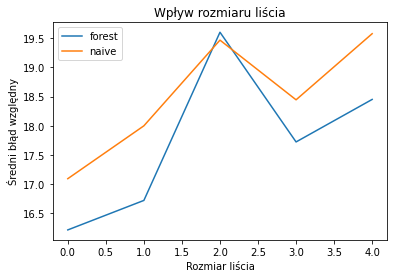

In [22]:
x_axis = range(5)
plt.plot(x_axis, forest_result, label="forest")
plt.plot(x_axis, naive_result, label="naive")
plt.xlabel('Rozmiar liścia')
plt.ylabel('Średni błąd względny')
plt.title('Wpływ rozmiaru liścia')
plt.legend()
plt.show()

In [15]:
pd.DataFrame(naive_result).describe()

,0
count,5.000000
mean,18.516114
std,1.040240
min,17.092946
25%,17.998900
50%,18.444408
75%,19.467005
max,19.577313


In [16]:
.head()

SyntaxError: invalid syntax (<ipython-input-16-c422e9c6d0e7>, line 1)

In [17]:
forest.trees[0]


        min_split_size: 30
        number_of_predictors_to_draw: 4
        
        Node:
            if <= 4_6.35:
                
        Node:
            if <= 5_-2.48:
                Leaf: 0.050909090909090876
            else:
                
        Node:
            if <= 4_2.84:
                Leaf: -0.06470588235294115
            else:
                
        Node:
            if <= 1_5.0:
                
        Node:
            if <= 2_-0.64:
                Leaf: 0.038749999999999986
            else:
                Leaf: -0.02375  
        
            else:
                Leaf: -0.04793103448275862  
          
          
        
            else:
                
        Node:
            if <= 5_-0.41:
                Leaf: 0.12666666666666665
            else:
                
        Node:
            if <= 4_7.92:
                Leaf: 0.04799999999999999
            else:
                Leaf: -0.007307692307692297  
          
          
        
     

In [18]:
forest_result

[16.215191533267472,
 16.72060521315019,
 19.60209989137454,
 17.722650295156438,
 18.450999307366292]

In [19]:
naive_result

[17.09294560872125,
 17.99890019114666,
 19.467005225407306,
 18.44440800143433,
 19.5773132157616]

In [20]:
test

array([ 1.  ,  5.81,  0.02,  1.  ,  5.81, -0.11, -0.05])

In [21]:
forest.predict(test)

-0.020513666753007875